# А/А - тест мобильного приложения
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

**Описание колонок**

`experimentVariant` – вариант эксперимента \
`version` – версия приложения \
`purchase` – факт покупки 

Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

- Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
- Посчитайте pvalue для каждой версии МП
- Найдите версии, где pvalue < 0.05
- Исключите версию с pvalue < 0.05 из основного датафрейма
- Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
- Вы нашли поломку

In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm

In [108]:
our_df = pd.read_csv('hw_aa.csv', sep=';')
our_df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [18]:
our_df.isnull().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [20]:
our_df = our_df.drop(columns=our_df.columns[0])
our_df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [24]:
df_group_one = our_df.query('experimentVariant == 1')
df_group_zero = our_df.query('experimentVariant == 0')
group_one = df_group_one.purchase
group_zero = df_group_zero.purchase
df_group_one.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
5,1679091c5a880faf6fb5e6087eb1b2dc,1,v2.8.0,0


In [82]:
n_size = 1000
sample_size = 1000
result = []
n_sum = 0
for _ in tqdm(range(n_size)):
    sample_one = np.array(group_one.sample(sample_size))
    sample_two = np.array(group_zero.sample(sample_size))

    pvalue = stats.ttest_ind(sample_one, sample_two, equal_var = False).pvalue
    if pvalue < 0.05:
        result.append(pvalue)
        n_sum += 1
print(f'FPR = {n_sum / n_size}')

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 415.07it/s]

FPR = 0.941


Text(0.5, 1.0, 'Count p-value')

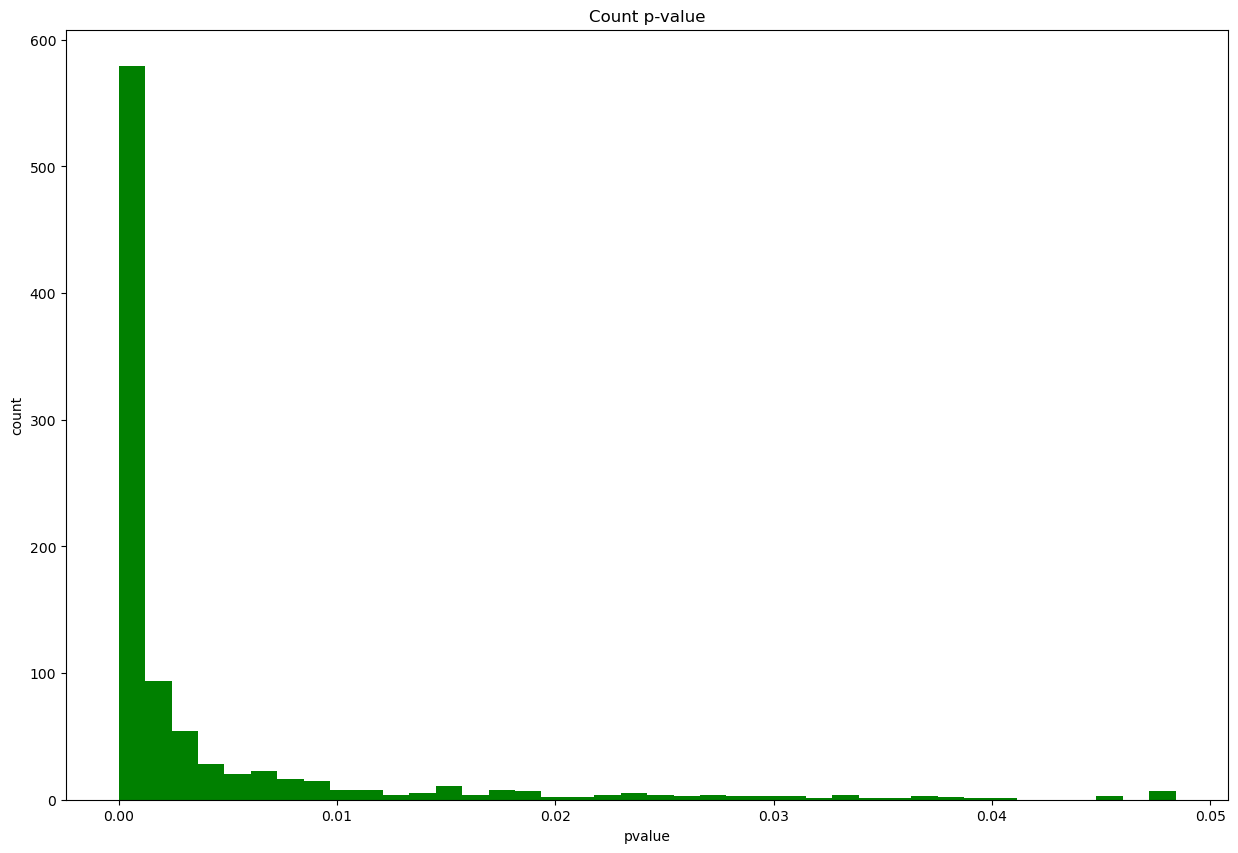

In [90]:
plt.figure(figsize=(15, 10))
plt.hist(result, bins=40, color='green')
plt.ylabel('count')
plt.xlabel('pvalue')
plt.title('Count p-value')

Видим, что FPR > 0.05 причем очень сильно. Будем искать в чем проблма. Предположим, что конверсия в какой-то из групп будет слишком низкой. для этого сгруппируем сначала по экспериментной группе (0 и 1) и проверим тут конверсию. Если не найдем аномалии, тогда сгруппируем по версиям и посчитаем конверсию по каждой версии нашего приложения

In [154]:
conv = our_df.groupby(our_df.experimentVariant, as_index=False).agg({'uid' : 'count', 'purchase' : 'sum'})
conv['conversion'] = conv['purchase'] / conv['uid']
conv

,experimentVariant,uid,purchase,conversion
0,0,63102,1511,0.023945
1,1,63916,3403,0.053242


In [156]:
conv_for_vers = our_df.groupby(['experimentVariant', 'version']).agg({'uid' : 'count', 'purchase' : 'sum'})
conv_for_vers['conversion'] = conv_for_vers['purchase'] / conv_for_vers['uid']
conv_for_vers

uid  purchase  conversion
experimentVariant version                              
0                 v2.8.0    41283        41    0.000993
                  v2.9.0    11921       890    0.074658
                  v3.7.4.0   4204       252    0.059943
                  v3.8.0.0   5694       328    0.057604
1                 v2.8.0    41552      1895    0.045606
                  v2.9.0    12033       858    0.071304
                  v3.7.4.0   4221       266    0.063018
                  v3.8.0.0   6110       384    0.062848

Видим, что в версии 2.8.0 слишком уж низкая конверсия в варианте 0. Будем проводить A/A тест для каждой версии.

In [175]:
n_size = 1000
n_sample = 1000
array_version = our_df['version'].unique()

 25%|███████████▎                                 | 1/4 [00:01<00:05,  1.97s/it]

FPR = 1.0 for version: v2.8.0


 50%|██████████████████████▌                      | 2/4 [00:03<00:03,  1.51s/it]

FPR = 0.035 for version: v2.9.0


 75%|█████████████████████████████████▊           | 3/4 [00:04<00:01,  1.26s/it]

FPR = 0.046 for version: v3.7.4.0


100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.29s/it]

FPR = 0.051 for version: v3.8.0.0


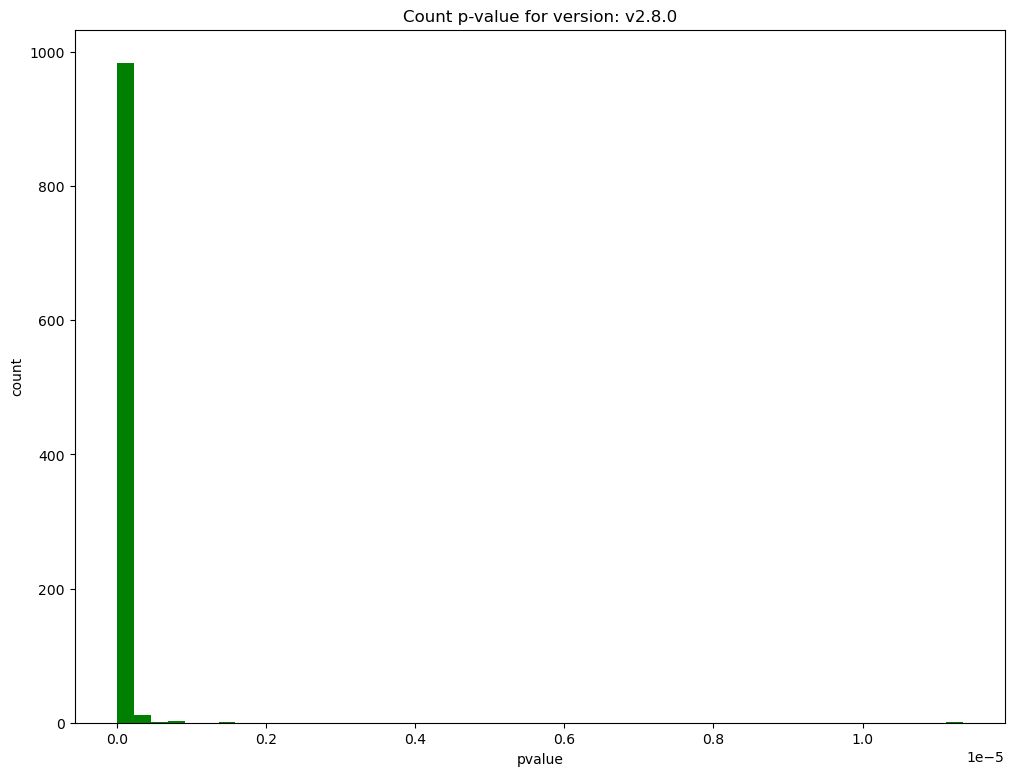

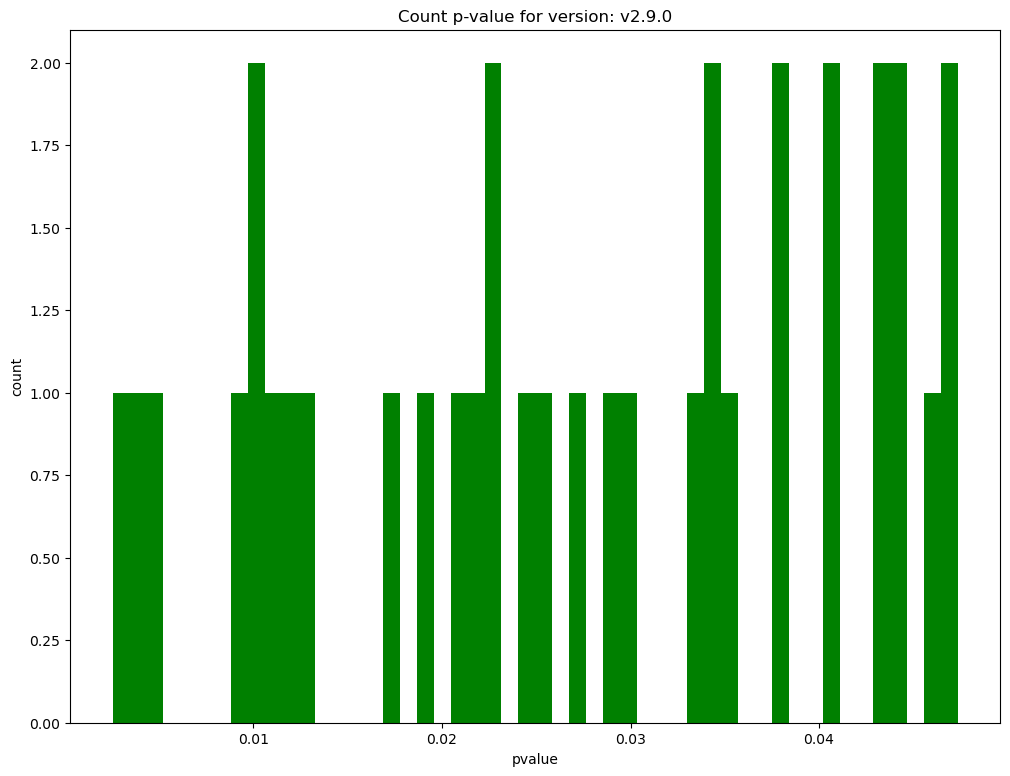

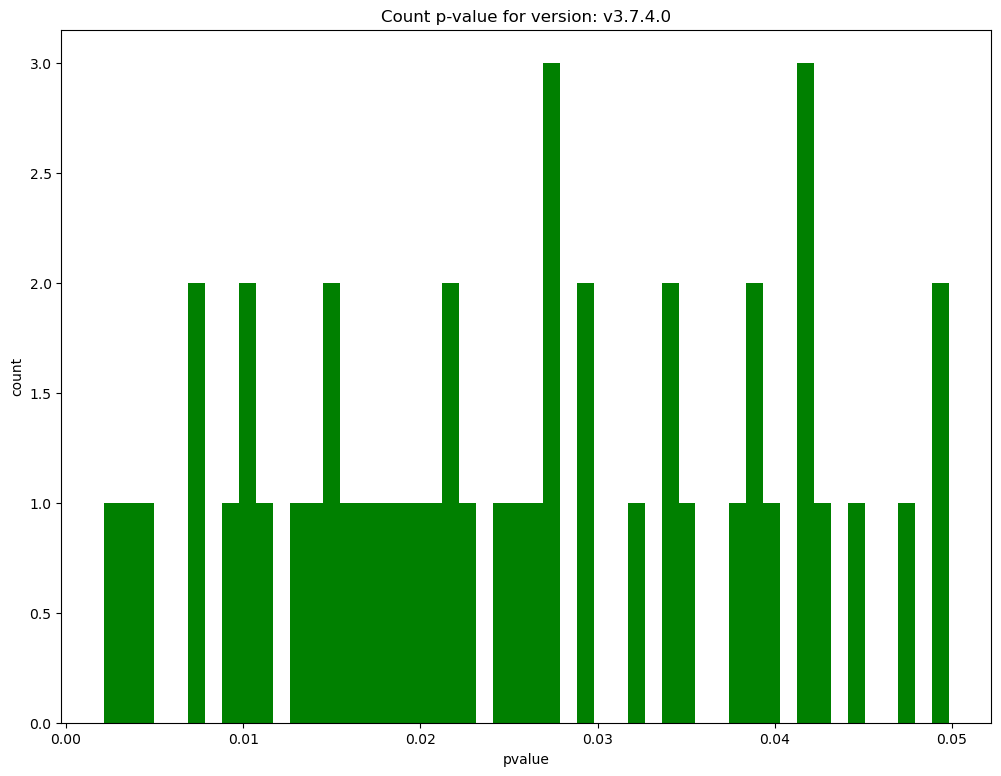

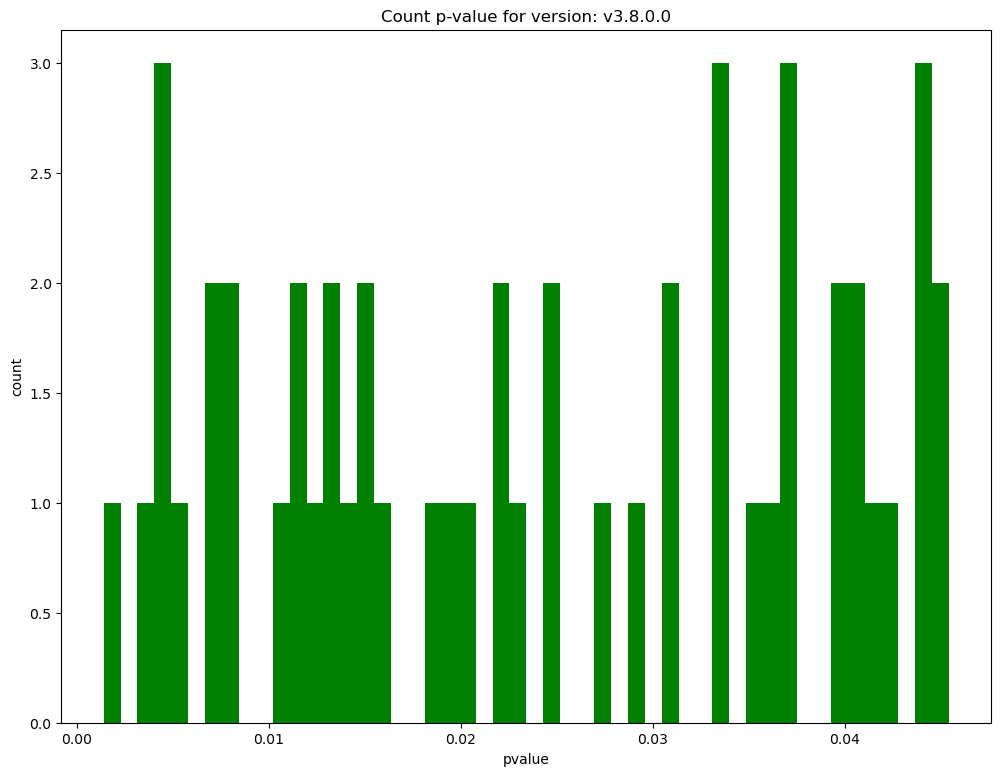

In [179]:
for ver in tqdm(array_version):
    group_one = df_group_one.query('version == @ver')['purchase']
    group_two = df_group_zero.query('version == @ver')['purchase']
    result_inner = []
    sum_fpr = 0
    
    for _ in range(n_size):
        sample_one = np.array(group_one.sample(n_sample))
        sample_two = np.array(group_two.sample(n_sample))

        pvalue = stats.ttest_ind(sample_one, sample_two, equal_var=False).pvalue
        if pvalue < 0.05:
            sum_fpr += 1
            result_inner.append(pvalue)

    plt.figure(figsize=(12, 9))
    plt.hist(result_inner, bins=50, color='green')
    plt.ylabel('count')
    plt.xlabel('pvalue')
    plt.title(f'Count p-value for version: {ver}')
    print(f'FPR = {sum_fpr / n_size} for version: {ver}')

Мы видим, что FPR для версии 2.8.0 равен еденице, что капельку выше 0.05. Теперь попробуем вцелом исключить версию 2.8.0 из наших данных и посчитать FPR без учета этой версии

In [188]:
new_df = our_df.query("version == 'v2.9.0' or version == 'v3.7.4.0' or version == 'v3.8.0.0'")
df_one = new_df.query('experimentVariant == 1')['purchase']
df_zero = new_df.query('experimentVariant == 0')['purchase']
n_exp = 1000
n_sample = 1000
fpr = 0
result = []
for i in tqdm(range(n_exp)):
    group_one = np.array(df_one.sample(n_sample))
    group_two = np.array(df_zero.sample(n_sample))

    pvalue = stats.ttest_ind(group_one, group_two, equal_var=False).pvalue
    if pvalue < 0.05:
        fpr += 1
        result.append(pvalue)

print(f'FPR = {fpr / n_exp}')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 697.76it/s]

FPR = 0.05


Вот мы и нашли, в чем заключается аномалия: в нашей сплит-системе неверно были интерпретированы результаты тестирования версии 2.8.0. Если мы ее не будем брать в учет, то все будет работать идеально. Ну и разве что FPR может быть немного выше. чем 0.05, все потому что у нас слишком мало экспериментов - 1000. Если их увеличить, то все будет отлично)